# Test evaluation

In [1]:
# Retina quality plots
%config InlineBackend.figure_format = 'retina'

## Load data

In [2]:
import pandas as pd

BIN_THRESHOLDS = [0.5, 0.6, 0.7, 0.8, 0.9, 1]
BINNING_CRITERIONS = ['identity', 'sim']

# Format: {crit0: [bin0,bin1,...], crit1: [bin0,bin1,...]}
pos_to_pos_bins = {binning_crit: [pd.read_parquet(f'../../data/train_test_alignments/Galson_2016_pos_{int(threshold * 100)}_{binning_crit}.parquet') for threshold in BIN_THRESHOLDS] for binning_crit in BINNING_CRITERIONS}

In [3]:
pos_to_neg_bins = {
    crit: pd.read_parquet(f'../../data/train_test_alignments/Galson_2016_pos_to_neg_{crit}.parquet')
    for crit in BINNING_CRITERIONS
}

In [4]:
y_test = pd.read_parquet('../../data/targets_data/clusters/Galson_2016.parquet')['HepB']

y_test.head()

Cluster_ID
0     True
1    False
2    False
3    False
4     True
Name: HepB, dtype: bool

In [5]:
all_test_data = pd.read_parquet('../../data/combined/clustered/final/mode_seq/Galson_2016_single.parquet')

all_test_data.info()
all_test_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1682432 entries, 0 to 1682431
Data columns (total 26 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   num_errors     1682432 non-null  object
 1   redundancy     1682432 non-null  int64 
 2   name           1682432 non-null  int64 
 3   seq            1682432 non-null  object
 4   v              1682432 non-null  object
 5   cdr3           1682432 non-null  object
 6   original_name  1682432 non-null  object
 7   errors         1682432 non-null  object
 8   j              1682432 non-null  object
 9   data           1682432 non-null  object
 10  Longitudinal   1682432 non-null  object
 11  Chain          1682432 non-null  object
 12  Author         1682432 non-null  object
 13  Isotype        1682432 non-null  object
 14  Age            1682432 non-null  object
 15  Size_igblastn  1682432 non-null  int64 
 16  Disease        1682432 non-null  object
 17  Link           1682432 non-

,num_errors,redundancy,name,seq,v,cdr3,original_name,errors,j,data,...,Disease,Link,BSource,BType,Subject,Species,Vaccine,Size,cdr3_len,Cluster_ID
0,0,1,63311,SLRLSCAASGFIFSSYVMSWVRQAPGKGLEWVSAIIGSGGTTFYAD...,IGHV3-23*01,AKDPVEVATLFPHQDDVTNWFDP,108143,[None],IGHJ5*02,"{""fwh1"": {""24"": ""A"", ""25"": ""A"", ""26"": ""S"", ""20...",...,None,https://genomemedicine.biomedcentral.com/artic...,PBMC,HepB+B-cells,Subject-2492,human,HepB,231143,23,0
1,1,1,105558,SLRLSCAASEFTFSSYAVSWVRQAPGKGLEWVSAGSGTGGIKYYAD...,IGHV3-23*01,ARGPWGYCGGGDCPFPSYNWFDP,105427,"[('56', 'G')]",IGHJ5*02,"{""fwh1"": {""24"": ""A"", ""25"": ""A"", ""26"": ""S"", ""20...",...,None,https://genomemedicine.biomedcentral.com/artic...,PBMC,Unsorted-B-Cells,Subject-2277,human,HepB,198956,23,1
2,0,1,89152,SLRLSCAASGFTFSGFAMGWVRQAPGKGLEWVSSLSDSGANRYYAD...,IGHV3-23*01,AKELGGGWFFGEVVSPRHNWFDP,121789,[None],IGHJ5*02,"{""fwh1"": {""24"": ""A"", ""25"": ""A"", ""26"": ""S"", ""20...",...,None,https://genomemedicine.biomedcentral.com/artic...,PBMC,Unsorted-B-Cells,Subject-2335,human,HepB,168255,23,2
3,1,1,641,SLRLSCAAFGFTFSNHAMNWVRQAPGKGLEWVSGIRGGGQSSFYAD...,IGHV3-23*01,AREIGYCTVSGPNPKKRGCWFDP,98214,"[('63', 'Q')]",IGHJ5*02,"{""fwh1"": {""24"": ""A"", ""25"": ""A"", ""26"": ""F"", ""20...",...,None,https://genomemedicine.biomedcentral.com/artic...,PBMC,Unsorted-B-Cells,Subject-2752,human,HepB,171405,23,3
4,0,1,25941,SLRLSCAGSGFTFSSFAMSWVRQAPGKGLEWVSAISASGASTYYAD...,IGHV3-23*01,AKDMRREGILRTMIRGVSCWFDP,86341,[None],IGHJ5*02,"{""fwh1"": {""24"": ""A"", ""25"": ""G"", ""26"": ""S"", ""20...",...,None,https://genomemedicine.biomedcentral.com/artic...,PBMC,HepB+B-cells,Subject-2277,human,HepB,121330,23,4


In [6]:
cluster_sizes = pd.read_parquet('../../data/combined/clustered/final/Galson_2016.parquet').groupby('Cluster_ID').size()

cluster_sizes.head()

Cluster_ID
0    160
1     70
2     19
3     16
4     15
dtype: int64

## Evaluation

In [7]:
from bin.evaluation import evaluate_classifier

import os
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef, recall_score, roc_curve

def fpr(y_true, y_pred, sample_weight=None):
    return roc_curve(y_true, y_pred, sample_weight=sample_weight)[0][1]

METRICS = [
    ('F1', f1_score),
    ('Accuracy', accuracy_score),
    ('MCC', matthews_corrcoef),
    ('Recall', recall_score),
    ('FPR', fpr)
]

def eval_models(y_true, data_dir, models, metrics=METRICS, sample_weights=None):
    for model in models:
        predictions_path = f'../../data/RoBERTa/predictions/{data_dir}/{model}.npy'
        
        if not os.path.exists(predictions_path):
            continue
        
        print(model)
        print('-' * 40)
        preds = np.load(predictions_path)
        evaluate_classifier(y_true, preds.argmax(1), preds[:,1], metrics, sample_weights=sample_weights)
        
def models_from_dir(dir_path):
    return sorted([filename for filename in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path, filename)) and not filename.startswith('.')])

### Heavy - non-weighted

In [8]:
heavy_model_dirs = sorted(models_from_dir('../../models/RoBERTa/mode_seq_heavy/subject_split_neg_subs_full/'))
heavy_model_dirs

['02_small_pretrained_2000epochs', '03_frozen_small_pretrained_2000epochs']

02_small_pretrained_2000epochs
----------------------------------------
Metric values:

F1: 0.162
Accuracy: 0.613
MCC: -0.044
Recall: 0.274
FPR: 0.333




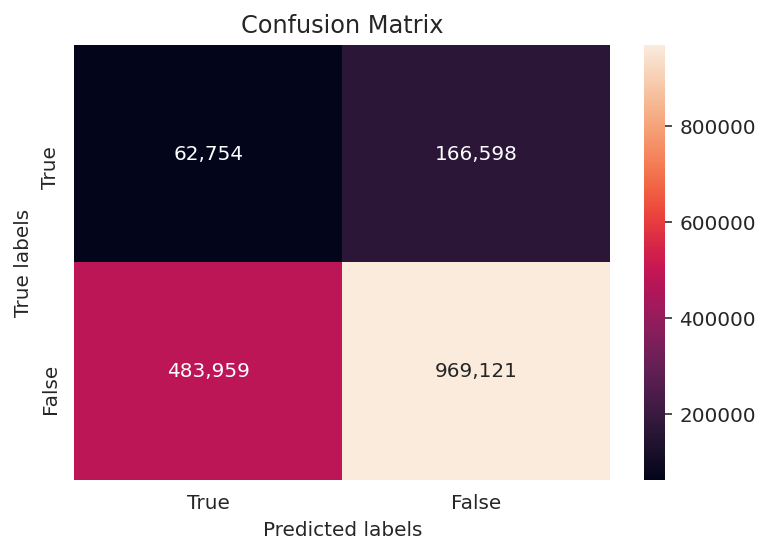

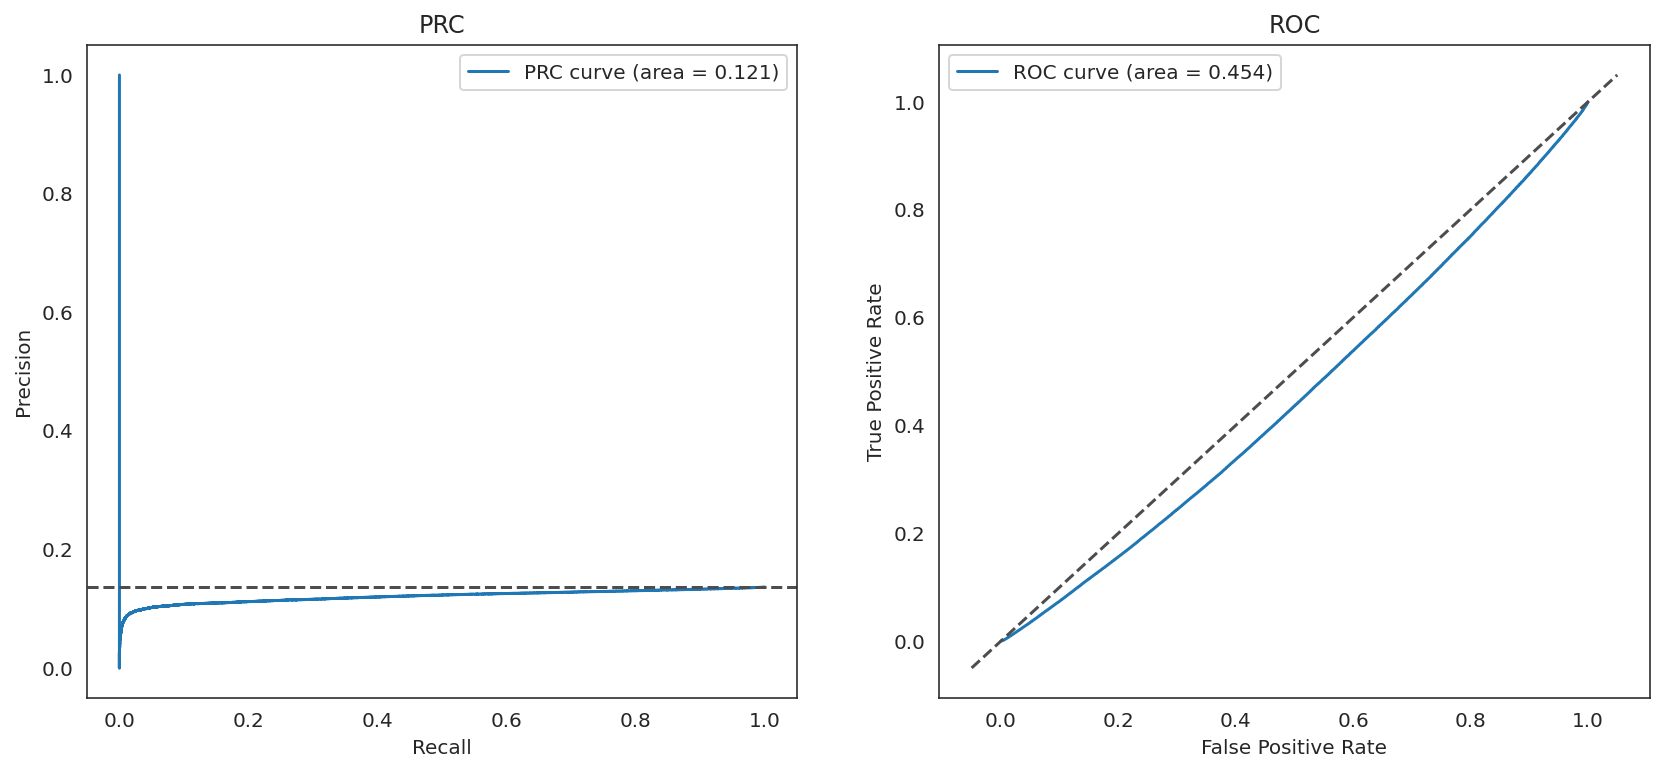

03_frozen_small_pretrained_2000epochs
----------------------------------------
Metric values:

F1: 0.161
Accuracy: 0.653
MCC: -0.030
Recall: 0.244
FPR: 0.283




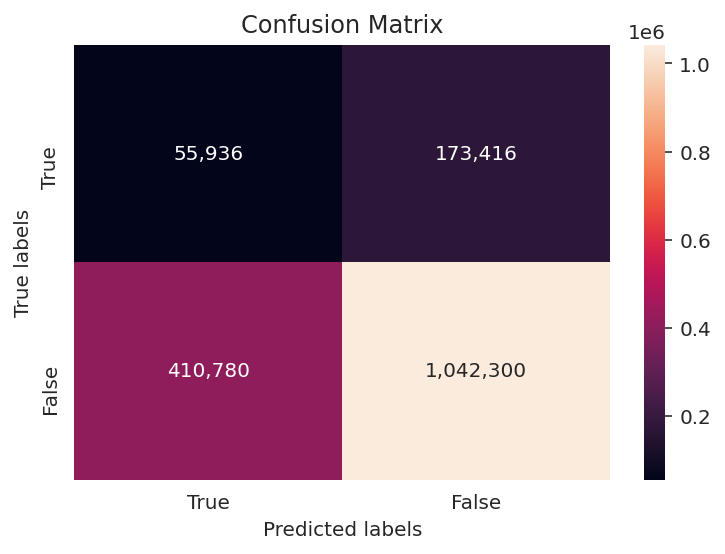

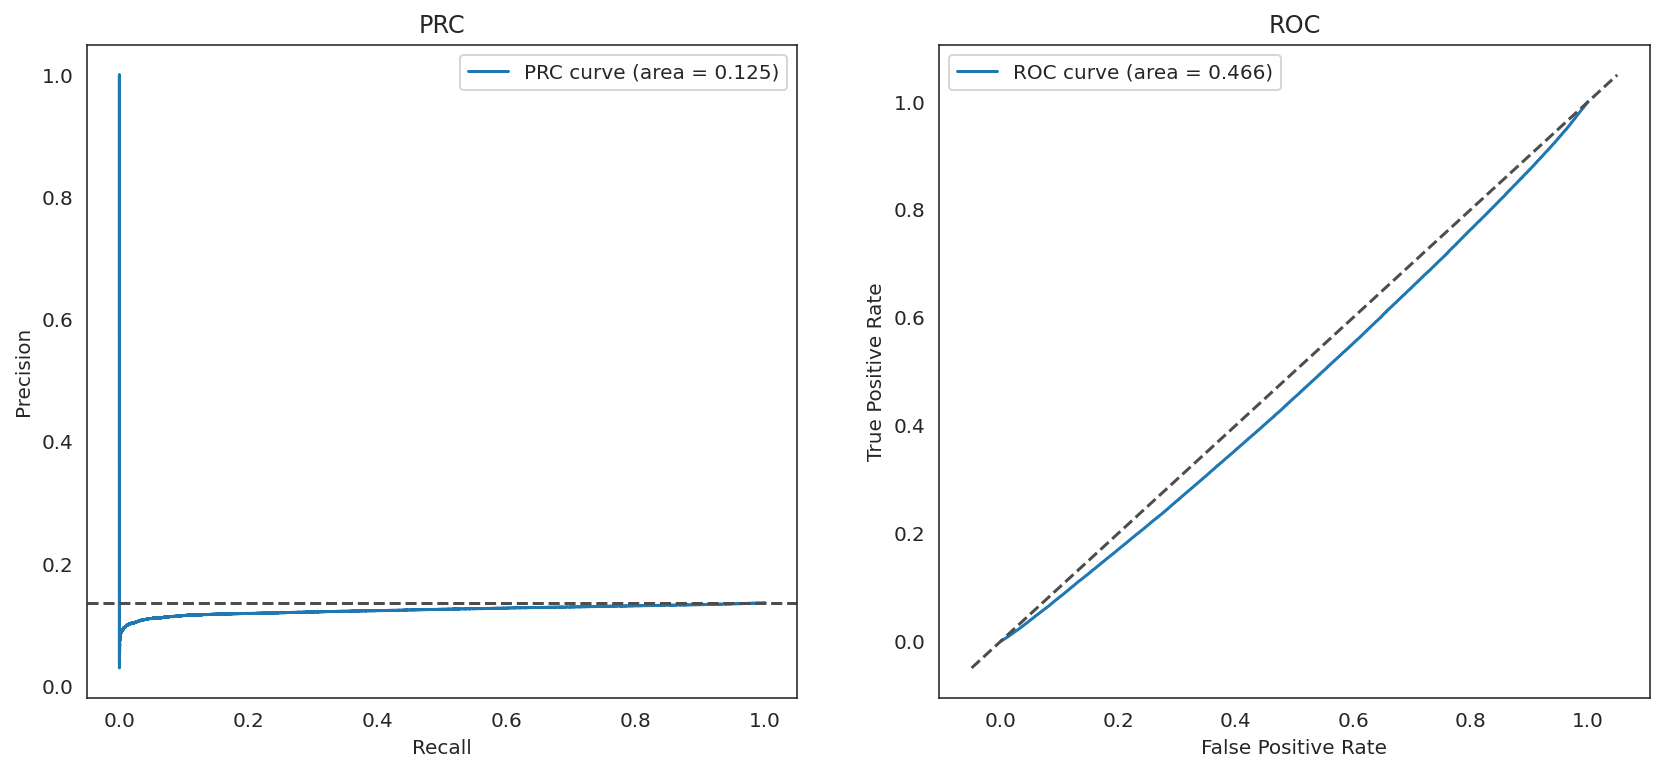

In [9]:
eval_models(y_test, 'test_heavy', heavy_model_dirs)

### Heavy - weighted

02_small_pretrained_2000epochs
----------------------------------------
Metric values:

F1: 0.333
Accuracy: 0.569
MCC: 0.016
Recall: 0.349
FPR: 0.333




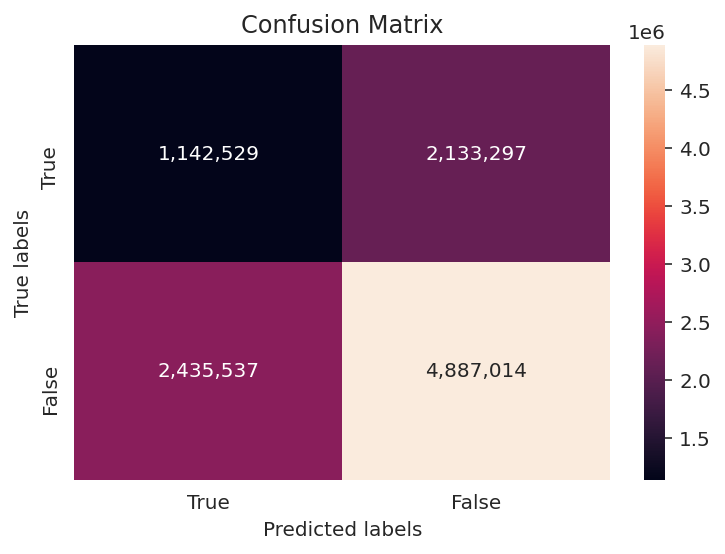

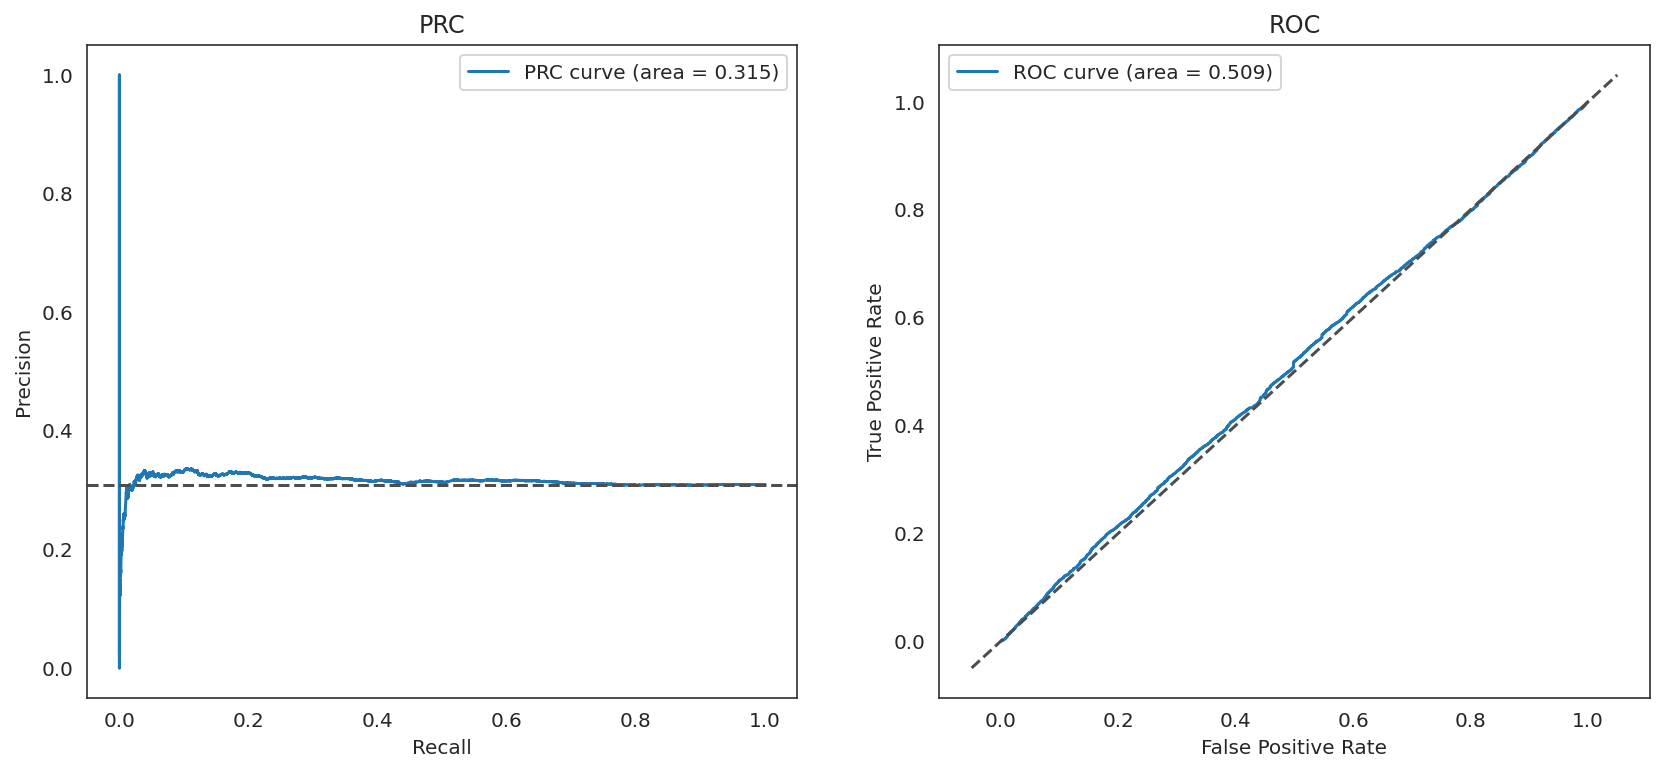

03_frozen_small_pretrained_2000epochs
----------------------------------------
Metric values:

F1: 0.305
Accuracy: 0.592
MCC: 0.018
Recall: 0.289
FPR: 0.272




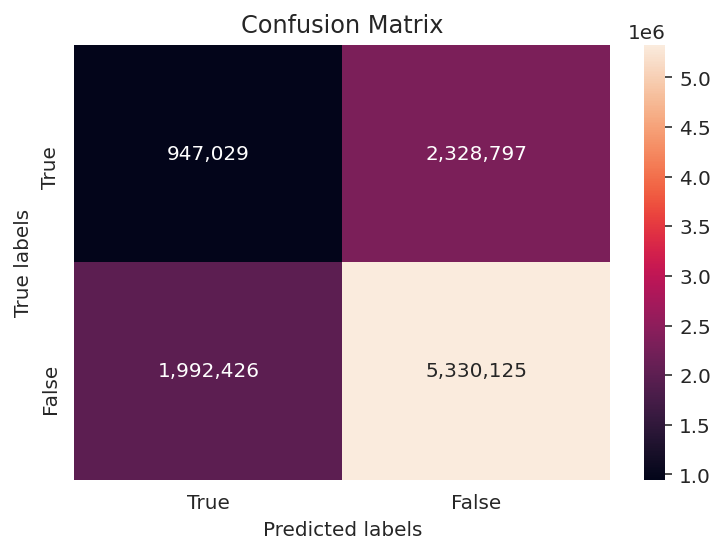

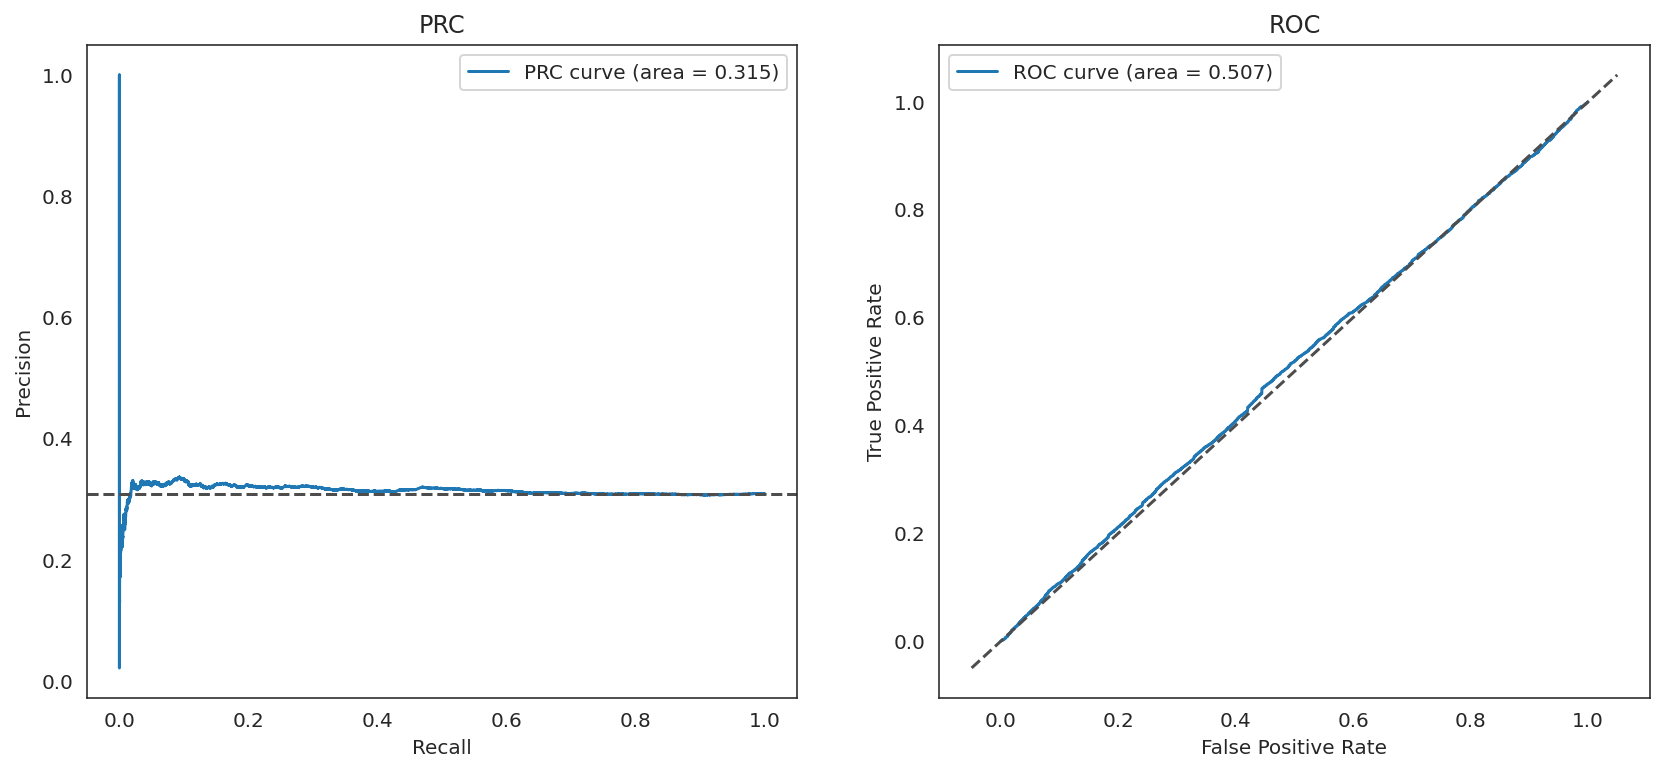

In [10]:
eval_models(y_test, 'test_heavy', heavy_model_dirs, sample_weights=cluster_sizes)

### CDR3 - non-weighted

In [11]:
cdr3_model_dirs = sorted(models_from_dir('../../models/RoBERTa/mode_seq/subject_split_neg_subs_full/'))
cdr3_model_dirs

['02_small_pretrained_2000epochs', '03_frozen_small_pretrained_2000epochs']

02_small_pretrained_2000epochs
----------------------------------------
Metric values:

F1: 0.195
Accuracy: 0.450
MCC: -0.047
Recall: 0.489
FPR: 0.556




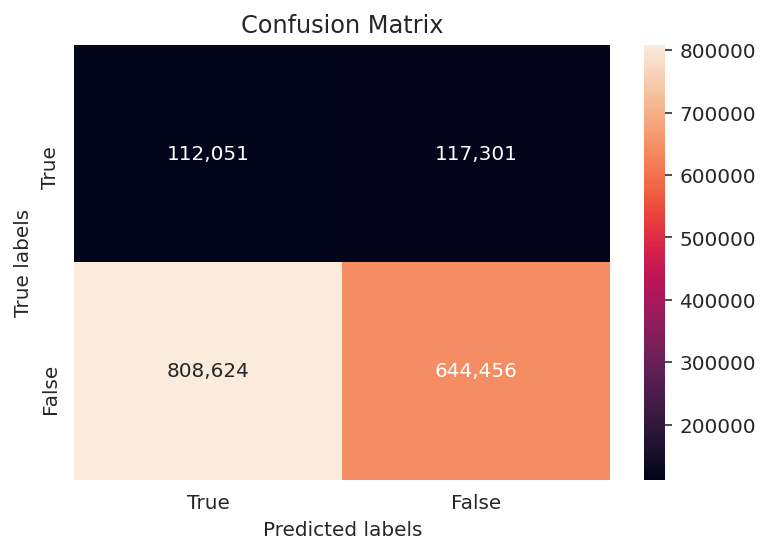

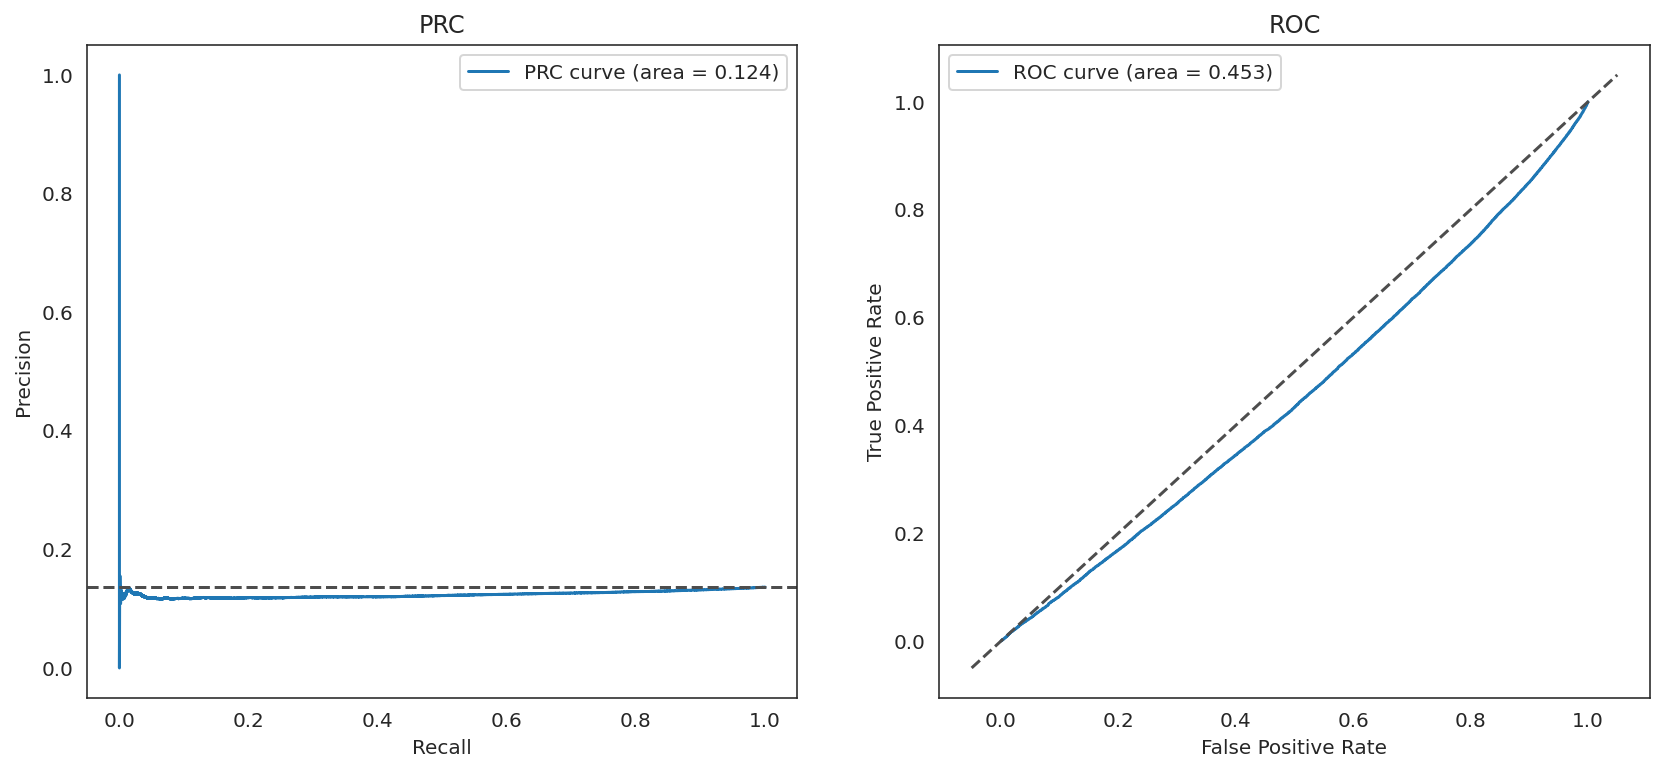

03_frozen_small_pretrained_2000epochs
----------------------------------------
Metric values:

F1: 0.191
Accuracy: 0.507
MCC: -0.037
Recall: 0.428
FPR: 0.481




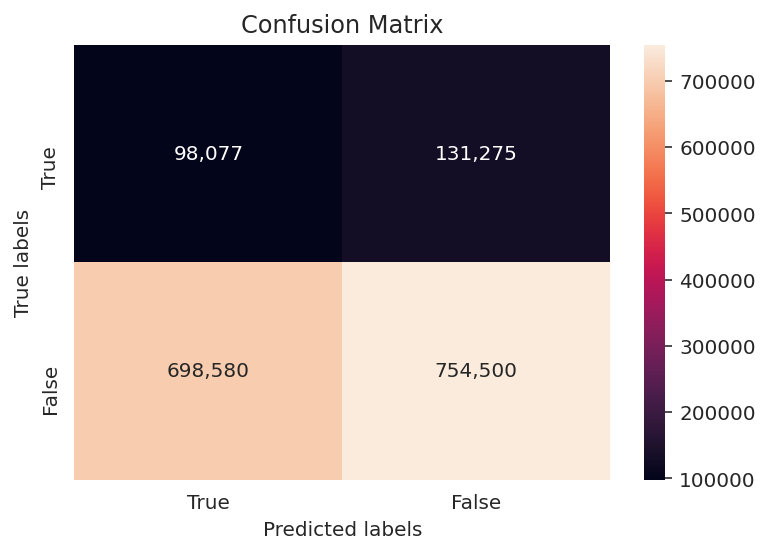

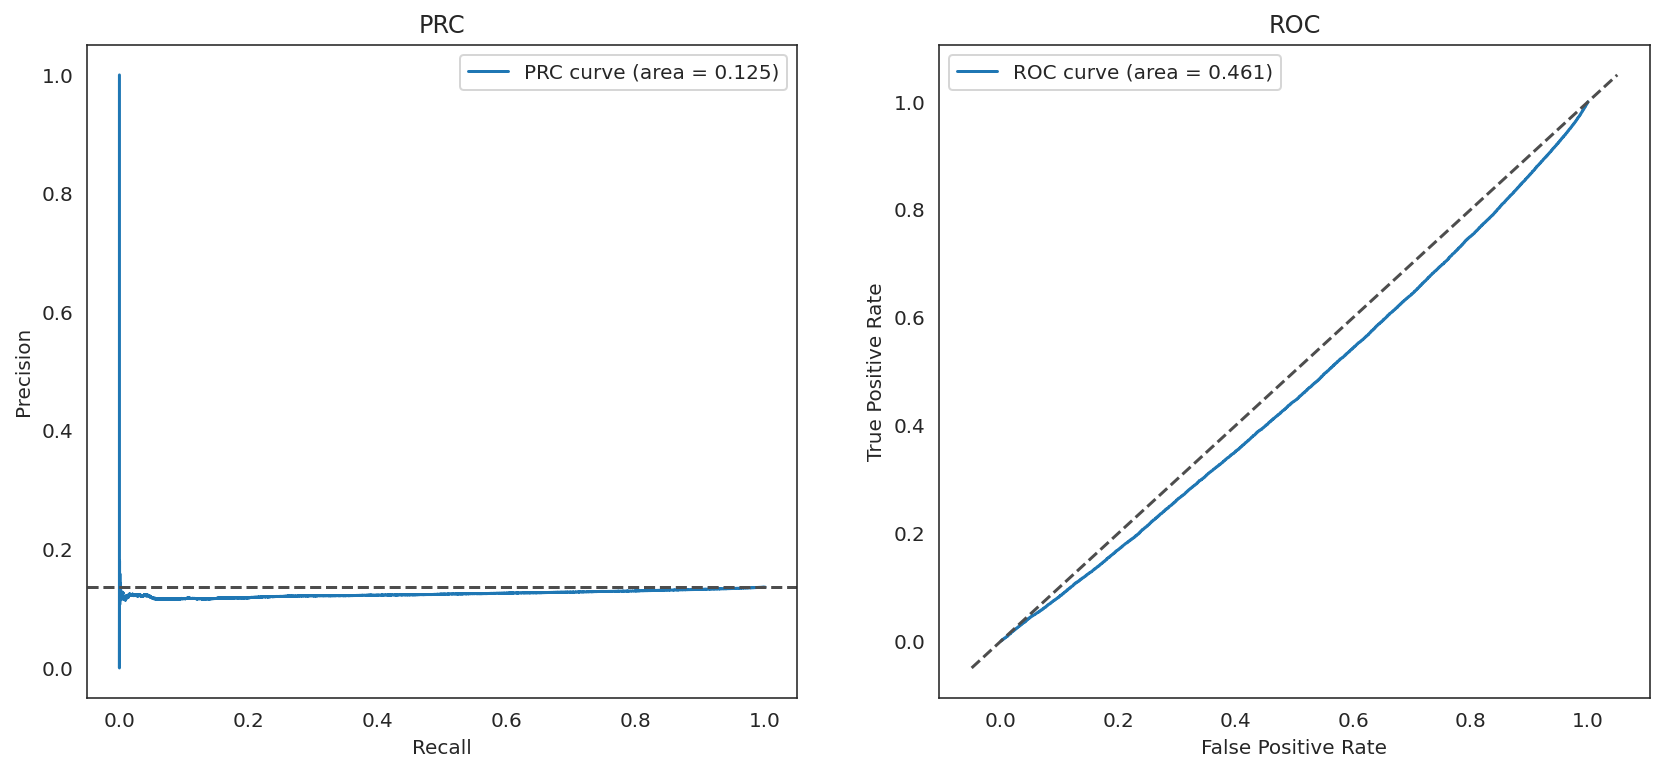

In [12]:
eval_models(y_test, 'test_cdr3', cdr3_model_dirs)

### CDR3 - weighted

02_small_pretrained_2000epochs
----------------------------------------
Metric values:

F1: 0.393
Accuracy: 0.462
MCC: -0.018
Recall: 0.564
FPR: 0.583




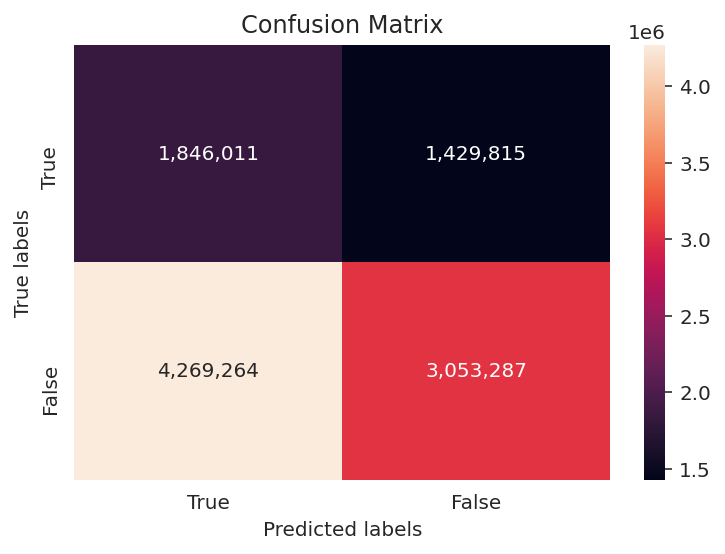

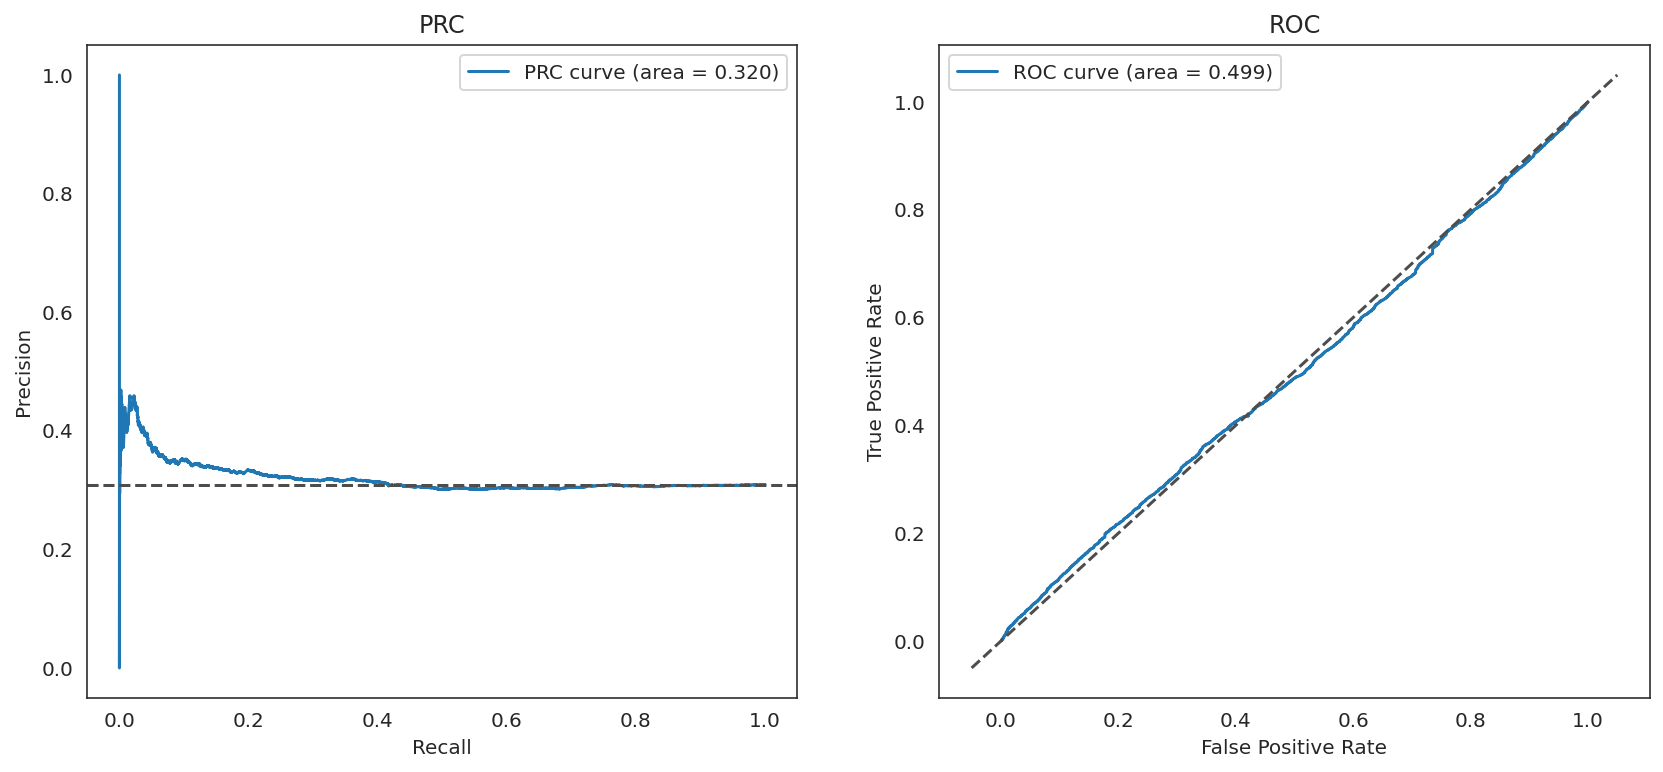

03_frozen_small_pretrained_2000epochs
----------------------------------------
Metric values:

F1: 0.386
Accuracy: 0.504
MCC: 0.008
Recall: 0.505
FPR: 0.497




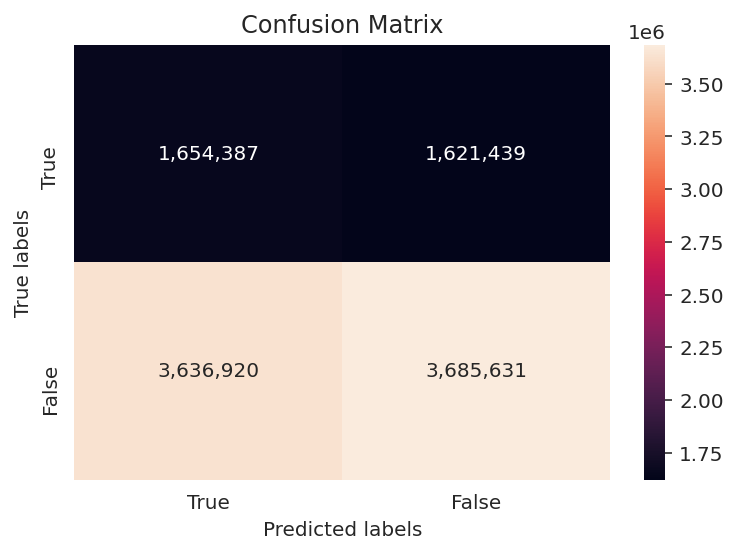

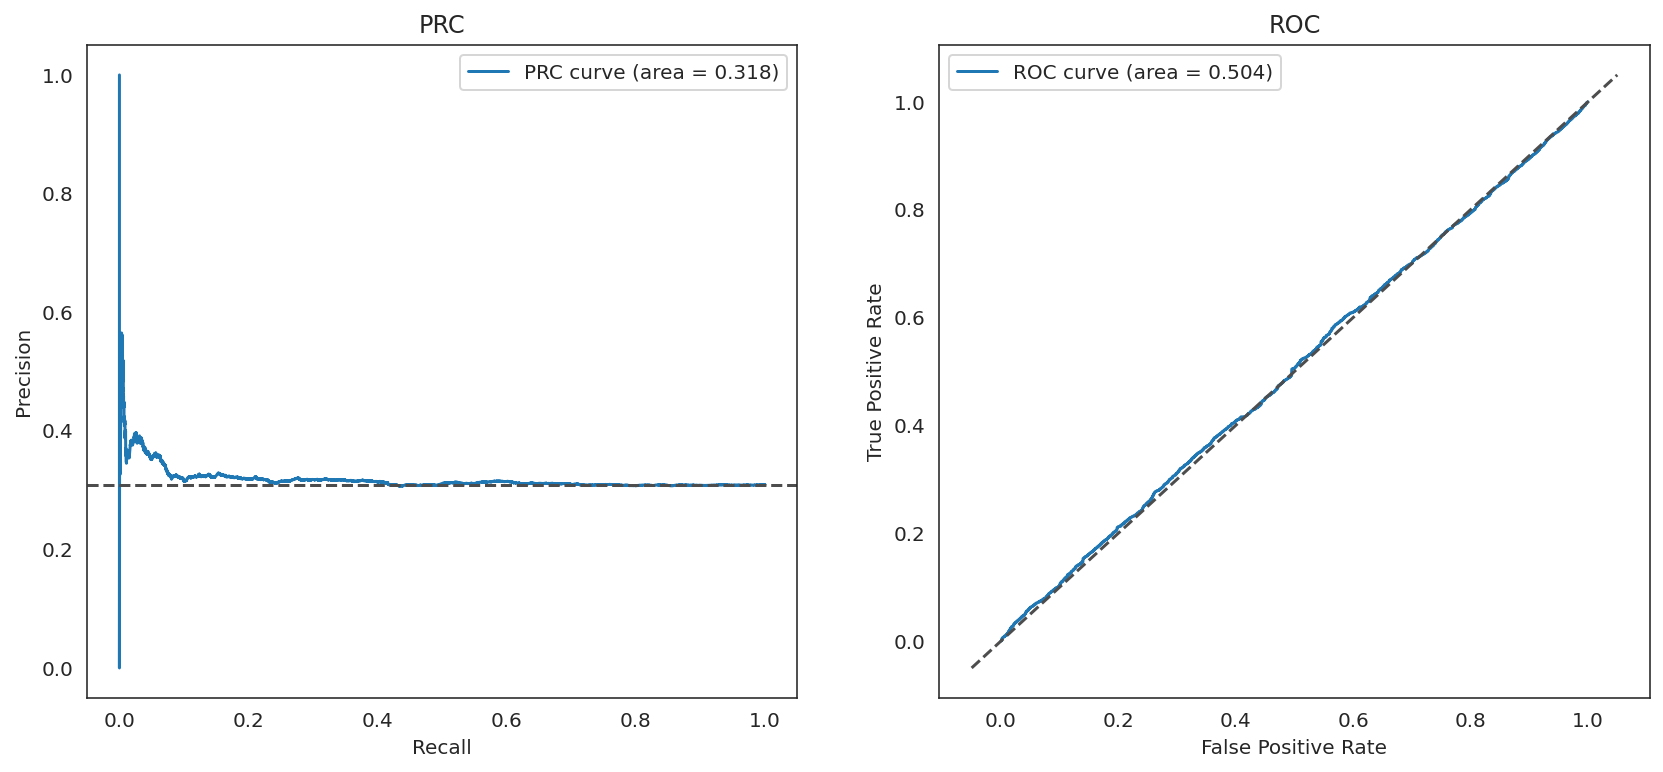

In [13]:
eval_models(y_test, 'test_cdr3', cdr3_model_dirs, sample_weights=cluster_sizes)

## Evaluation - positive sequences only

In [14]:
def pos_bins_matrix(pos_pos_bins=pos_to_pos_bins, pos_neg_bins=pos_to_neg_bins):
    """
    Converts positive-positive bins and positive-negative bins
    to a single "matrix-like" structure.
    """
    
    data_bins_matrix = {}
    
    for crit, bins in pos_pos_bins.items():
        crit_bins = []
        
        for binn in bins:
            pos_neg_bin = pos_neg_bins[crit].loc[binn.index]
            inner_bins = [binn.loc[pos_neg_bin[pos_neg_bin['Bin'] == thr].index] for thr in BIN_THRESHOLDS]
            crit_bins.append(inner_bins)
        
        data_bins_matrix[crit] = crit_bins
    
    return data_bins_matrix

In [15]:
def bins_predictions(all_predictions, data_bins, pos_threshold=None):
    """
    Extracts bins predictions from all predictions.
    """

    preds = []
    for outer_bin in data_bins:
        inner_preds = []

        for inner_bin in outer_bin:
            bin_preds = all_predictions.loc[inner_bin.index].values

            if pos_threshold:
                bin_preds = bin_preds[:,1] >= pos_threshold
            else:
                bin_preds = bin_preds.argmax(1)

            inner_preds.append(bin_preds)
        
        preds.append(inner_preds)
        
    return preds

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

tmp_thresholds = [0] + BIN_THRESHOLDS
PERC_BIN_THRESHOLDS = [
   f'{int(100 * tmp_thresholds[i-1])}-{int(100 * tmp_thresholds[i])}%' for i in range(1,len(tmp_thresholds))
]
    
def bins_performance_heatmap(rec_vals, weighted_rec_vals):
    for title_suffix, rec_vals in [('non-weighted', rec_vals), ('weighted', weighted_rec_vals)]:
        plt.figure()
        ax = sns.heatmap(rec_vals[::-1], annot=True, fmt='.2f',
                         xticklabels=PERC_BIN_THRESHOLDS,
                         yticklabels=PERC_BIN_THRESHOLDS[::-1])
        ax.set(xlabel='POS to NEG', ylabel='POS to POS', title=f'Test recall values ({title_suffix})')
    
    plt.show()

In [17]:
from sklearn.metrics import recall_score
import math
import numpy as np

from bin.evaluation import get_threshold

TARGET_FPR = 0.3
    
def bins_recalls(y_preds, sample_weights=None):
    sample_weights = sample_weights if sample_weights else [[None for _ in range(len(pr))] for pr in y_preds]
    
    rec_vals = []
    for threshold, y_pred_outer, bin_sample_weights in zip(BIN_THRESHOLDS, y_preds, sample_weights):

        inner_rec_vals = []
        for inner_threshold, y_pred, inner_bin_sample_weights in zip(BIN_THRESHOLDS, y_pred_outer, bin_sample_weights):
            y_true = np.ones(len(y_pred))
    
            rec_val = recall_score(y_true, y_pred, sample_weight=inner_bin_sample_weights)
            inner_rec_vals.append(rec_val)

        rec_vals.append(inner_rec_vals)

    return np.array(rec_vals)

def complete_bin_performance(models, 
                             data_dir, 
                             data_bins, 
                             sample_weights, 
                             original_data=all_test_data, 
                             y_true=y_test, 
                             original_sample_weights=cluster_sizes,
                             bins_preds_fn=bins_predictions,
                             bins_recalls_fn=bins_recalls,
                             plot_fn=bins_performance_heatmap):
    """
    Reports models' performance and returns corresponding recalls.
    """
    
    models_recalls = {}
    for model in models:
        print(model)
        print('-' * 40 + '\n')
        
        # Load predictions
        predictions_path = f'../../data/RoBERTa/predictions/{data_dir}/{model}.npy'
        preds_npy = np.load(predictions_path)
        preds_df = pd.DataFrame(preds_npy, index=original_data.index)
        
        # Get thresholds
        weighted_pos_threshold = get_threshold(y_true, preds_npy[:,1], target_fpr=TARGET_FPR, sample_weights=original_sample_weights)
        pos_threshold = get_threshold(y_true, preds_npy[:,1], target_fpr=TARGET_FPR)
        
        # Make predictions based on the thresholds
        weighted_preds = bins_preds_fn(preds_df, data_bins, pos_threshold=weighted_pos_threshold)
        preds = bins_preds_fn(preds_df, data_bins, pos_threshold=pos_threshold)
        
        # Bin performance
        weighted_recalls = bins_recalls_fn(weighted_preds, sample_weights)
        recalls = bins_recalls_fn(preds)
        
        # Plot
        if plot_fn:
            plot_fn(recalls, weighted_recalls)
        
        models_recalls[model] = (weighted_recalls, recalls)
        
    return models_recalls

In [18]:
heatmap_bins = pos_bins_matrix()

In [19]:
bin_cluster_sizes = {
    crit: [[cluster_sizes.loc[bin_data.index].values for bin_data in outer_bin] for outer_bin in data_bins]
    for crit, data_bins in heatmap_bins.items()
}

### Heavy - identity

02_small_pretrained_2000epochs
----------------------------------------



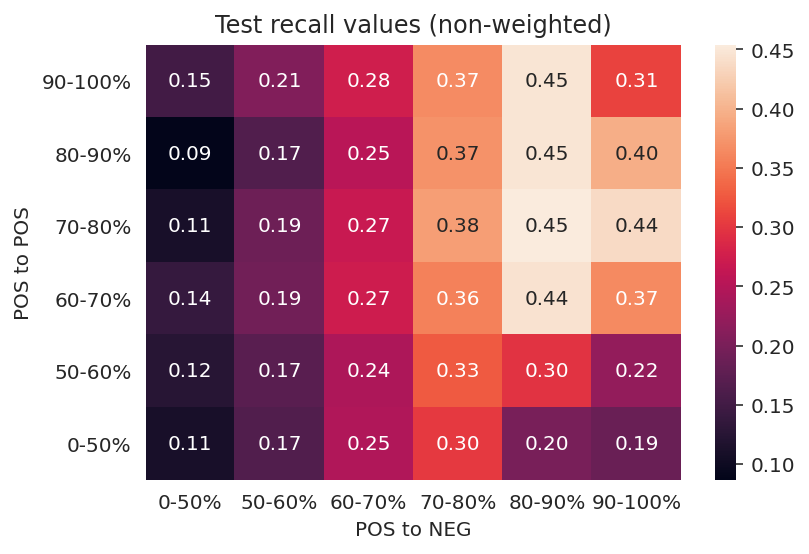

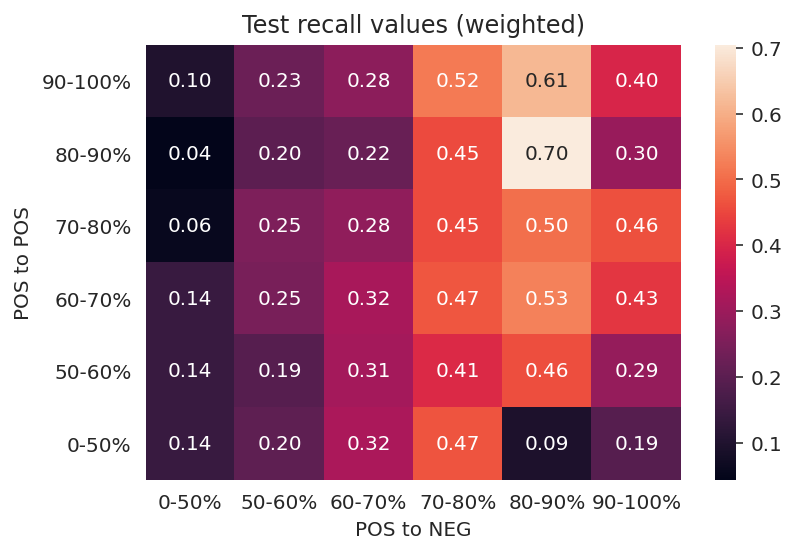

03_frozen_small_pretrained_2000epochs
----------------------------------------



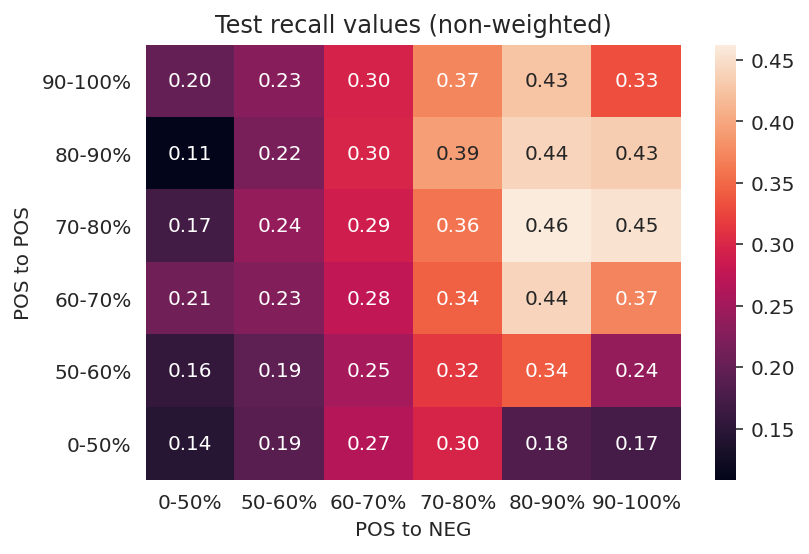

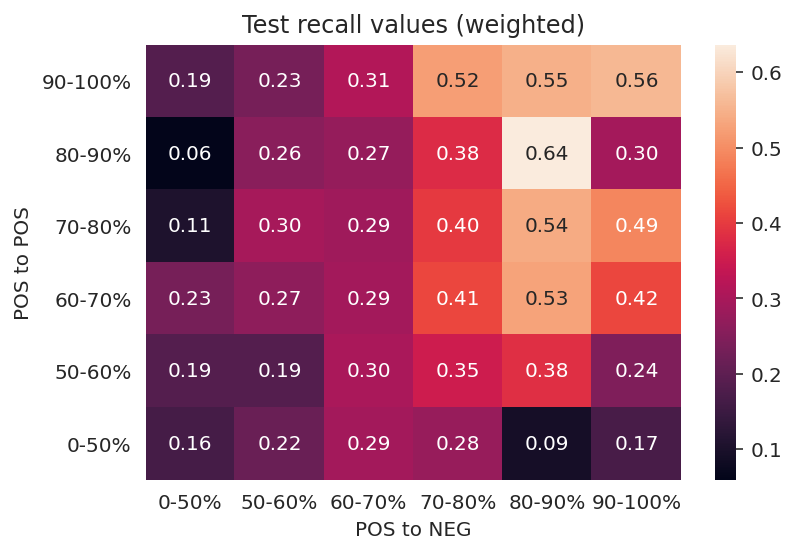

In [20]:
heavy_id_recalls = complete_bin_performance(heavy_model_dirs,
                                            'test_heavy',
                                            heatmap_bins['identity'], 
                                            sample_weights=bin_cluster_sizes['identity'])

### Heavy - similarity

02_small_pretrained_2000epochs
----------------------------------------



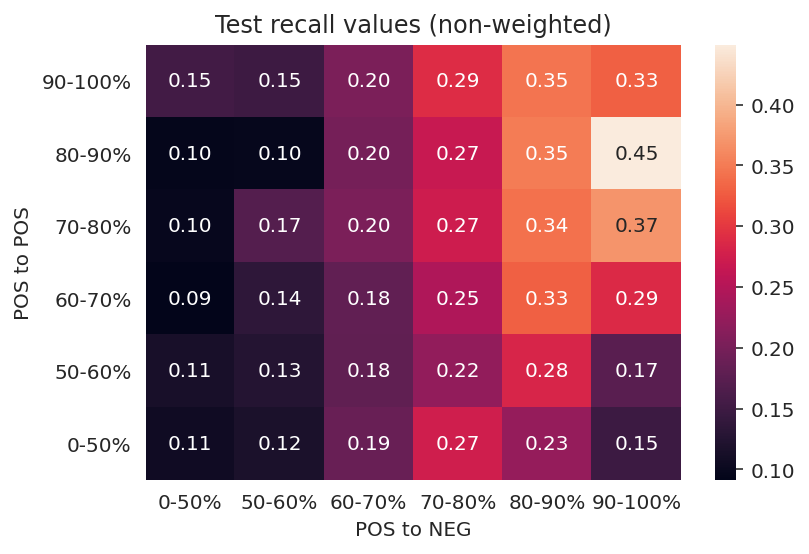

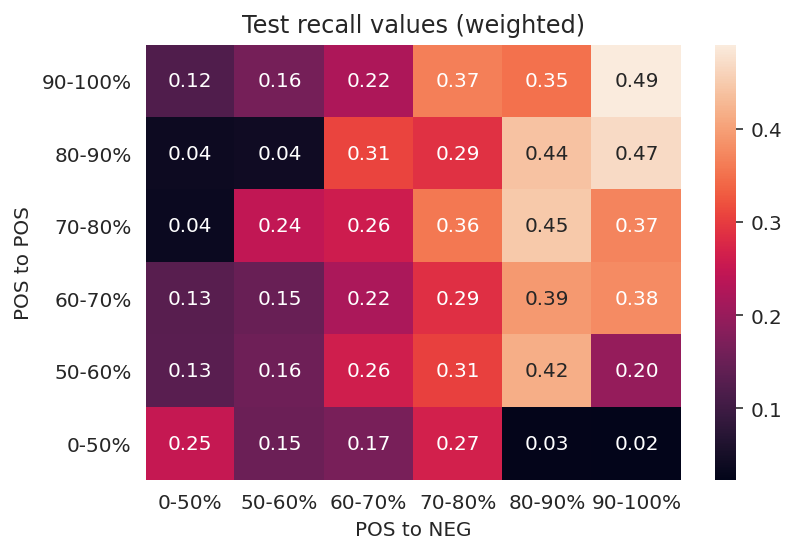

03_frozen_small_pretrained_2000epochs
----------------------------------------



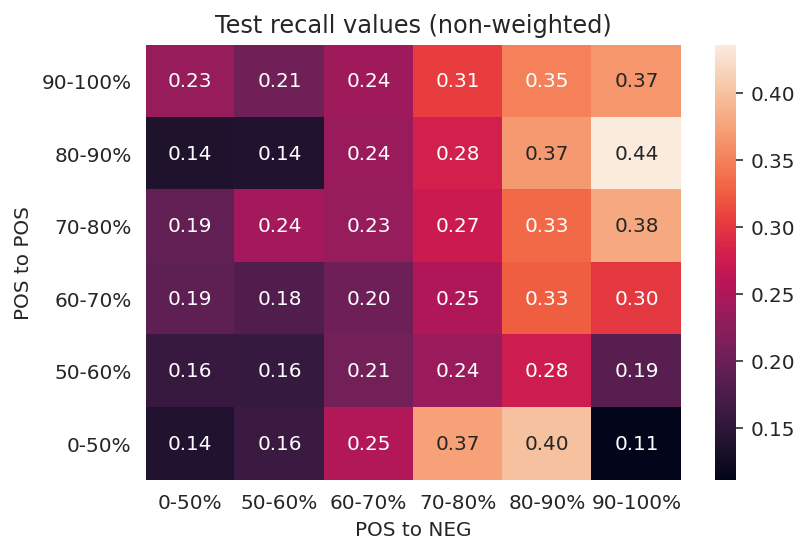

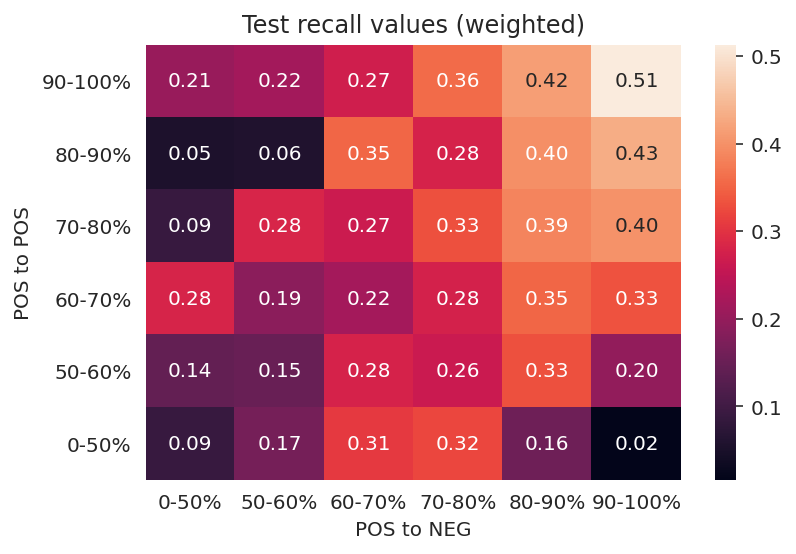

In [21]:
heavy_sim_recalls = complete_bin_performance(heavy_model_dirs,
                                             'test_heavy',
                                             heatmap_bins['sim'], 
                                             sample_weights=bin_cluster_sizes['sim'])

### CDR3 - identity

02_small_pretrained_2000epochs
----------------------------------------



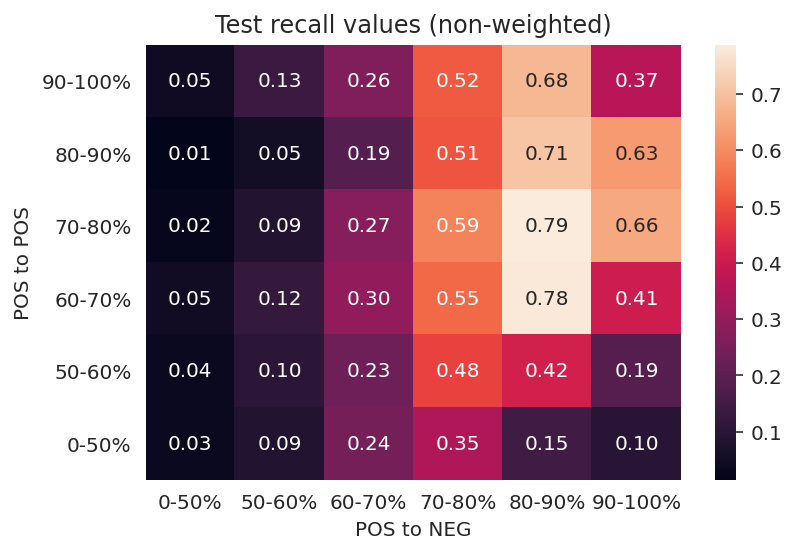

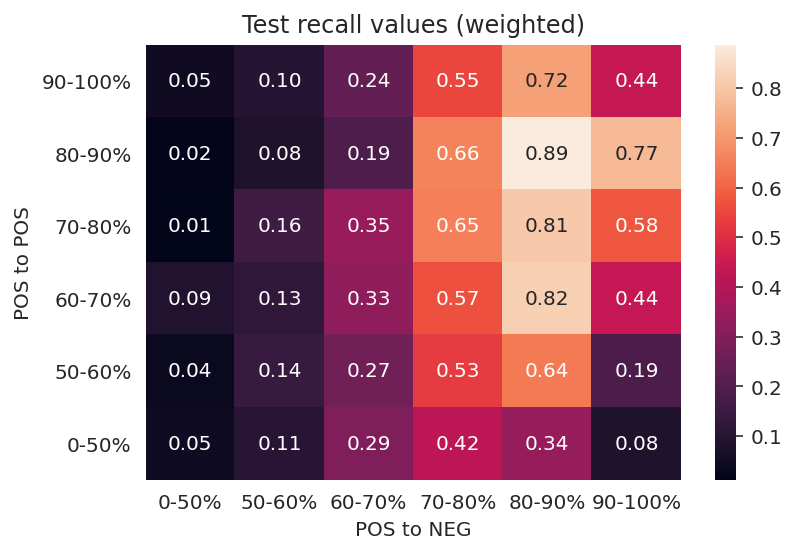

03_frozen_small_pretrained_2000epochs
----------------------------------------



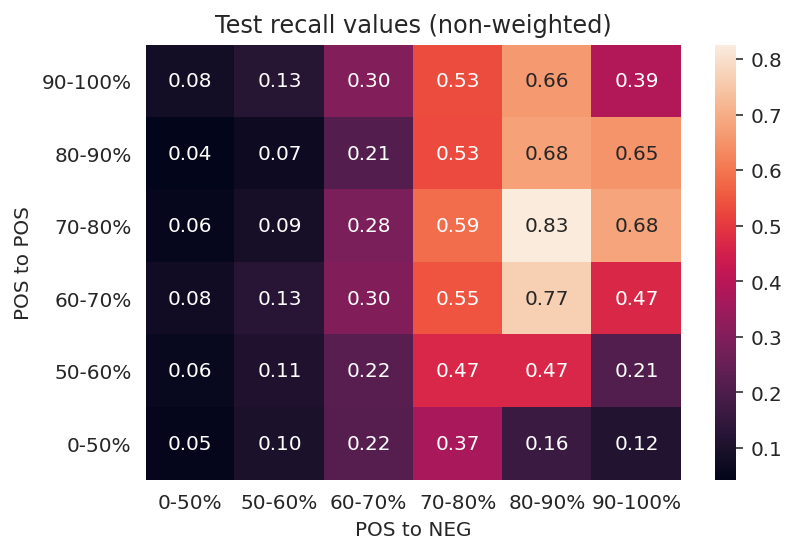

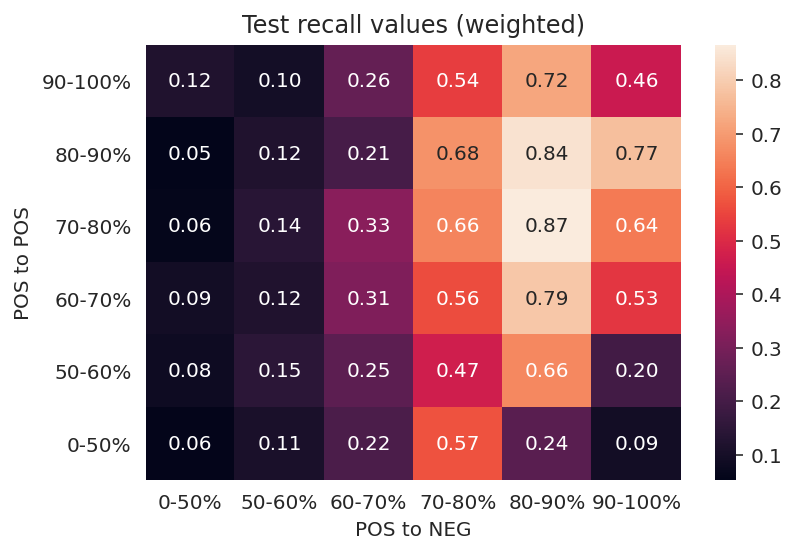

In [22]:
cdr3_id_recalls = complete_bin_performance(cdr3_model_dirs,
                                           'test_cdr3',
                                           heatmap_bins['identity'], 
                                           sample_weights=bin_cluster_sizes['identity'])

### CDR3 - similarity

02_small_pretrained_2000epochs
----------------------------------------



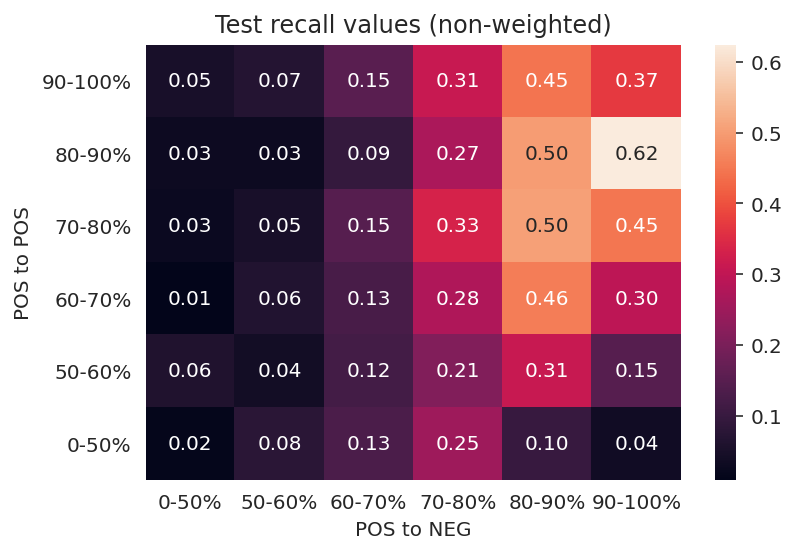

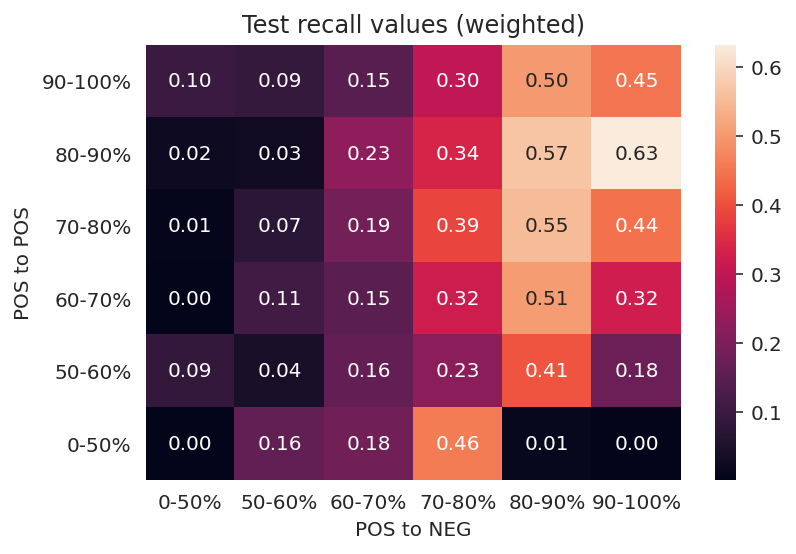

03_frozen_small_pretrained_2000epochs
----------------------------------------



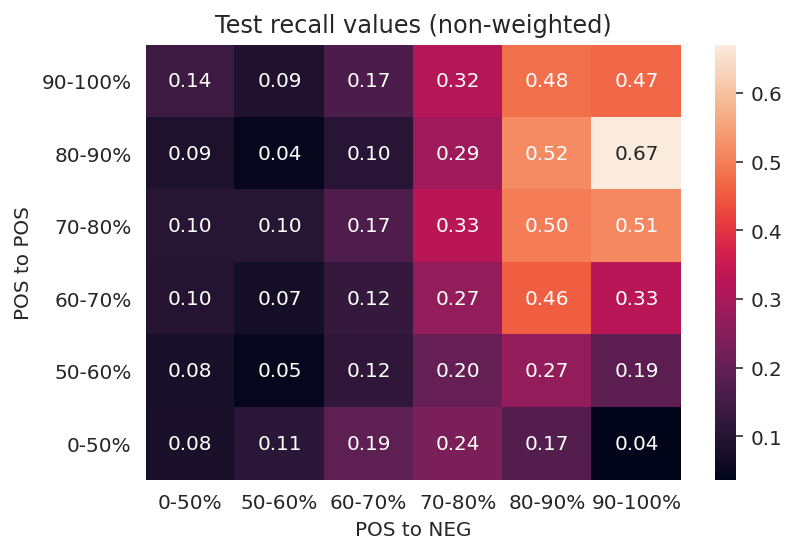

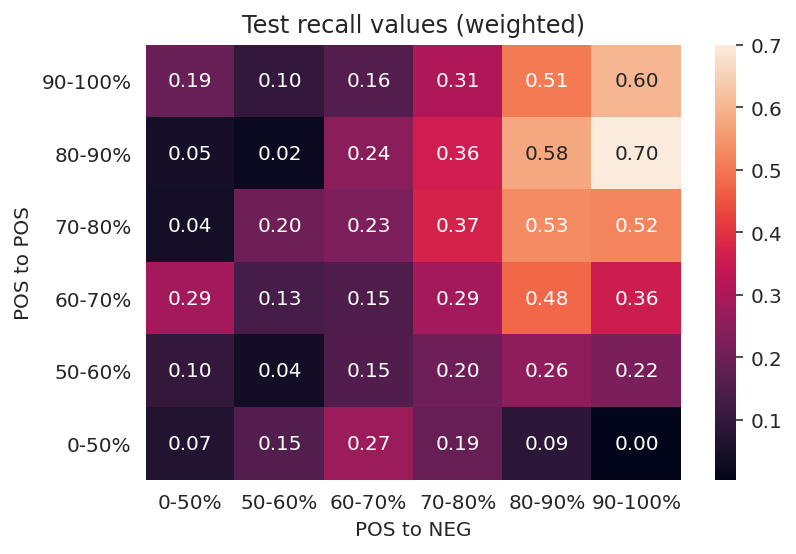

In [23]:
cdr3_sim_recalls = complete_bin_performance(cdr3_model_dirs,
                                            'test_cdr3',
                                            heatmap_bins['sim'], 
                                            sample_weights=bin_cluster_sizes['sim'])

## Sum-up evaluation - positive sequences only

In [24]:
import seaborn as sns

COLOR_PALETTE = sns.color_palette()

def lineplot_bins_performance(bin_recalls, criterion, fpr, ax=None):
    # Plotting
    for (model, recall_vals), color in zip(bin_recalls.items(), COLOR_PALETTE):
        # Recalls line
        if ax:
            sns.lineplot(x=BIN_THRESHOLDS, y=recall_vals, marker='o', label=model, color=color, ax=ax)
        else:
            ax = sns.lineplot(x=BIN_THRESHOLDS, y=recall_vals, marker='o', label=model, color=color)
        
        # FPR line
        ax.axhline(fpr, ls='--', linewidth=1, color=color)

    ax.set(title=f'Models\' recalls - data binned using {criterion}')

In [25]:
def bins_recalls_1d(y_preds, sample_weights=None):
    sample_weights = sample_weights if sample_weights else [None for _ in range(len(y_preds))]
    
    rec_vals = []
    for threshold, y_pred, bin_sample_weights in zip(BIN_THRESHOLDS, y_preds, sample_weights):
        y_true = np.ones(len(y_pred))
        rec_val = recall_score(y_true, y_pred, sample_weight=bin_sample_weights)
        rec_vals.append(rec_val)

    return np.array(rec_vals)

In [26]:
def bins_preds_1d(all_predictions, data_bins, pos_threshold=None):
    preds = []
    for binn in data_bins:
        bin_preds = all_predictions.loc[binn.index].values

        if pos_threshold:
            bin_preds = bin_preds[:,1] >= pos_threshold
        else:
            bin_preds = bin_preds.argmax(1)

        preds.append(bin_preds)
        
    return preds

In [27]:
bin_cluster_sizes = {
    crit: [cluster_sizes.loc[binn.index].values for binn in data_bins]
    for crit, data_bins in pos_to_pos_bins.items()
}

### Heavy - identity

In [28]:
heavy_id_recalls = complete_bin_performance(heavy_model_dirs,
                                            'test_heavy',
                                            pos_to_pos_bins['identity'], 
                                            sample_weights=bin_cluster_sizes['identity'],
                                            bins_preds_fn=bins_preds_1d,
                                            bins_recalls_fn=bins_recalls_1d,
                                            plot_fn=None)

02_small_pretrained_2000epochs
----------------------------------------

03_frozen_small_pretrained_2000epochs
----------------------------------------



### Heavy - similarity

In [29]:
heavy_sim_recalls = complete_bin_performance(heavy_model_dirs,
                                             'test_heavy',
                                             pos_to_pos_bins['sim'], 
                                             sample_weights=bin_cluster_sizes['sim'],
                                             bins_preds_fn=bins_preds_1d,
                                             bins_recalls_fn=bins_recalls_1d,
                                             plot_fn=None)

02_small_pretrained_2000epochs
----------------------------------------

03_frozen_small_pretrained_2000epochs
----------------------------------------



### CDR3 - identity

In [30]:
cdr3_id_recalls = complete_bin_performance(cdr3_model_dirs,
                                           'test_cdr3',
                                            pos_to_pos_bins['identity'], 
                                            sample_weights=bin_cluster_sizes['identity'],
                                            bins_preds_fn=bins_preds_1d,
                                            bins_recalls_fn=bins_recalls_1d,
                                            plot_fn=None)

02_small_pretrained_2000epochs
----------------------------------------

03_frozen_small_pretrained_2000epochs
----------------------------------------



### CDR3 - similarity

In [31]:
cdr3_sim_recalls = complete_bin_performance(cdr3_model_dirs,
                                            'test_cdr3',
                                             pos_to_pos_bins['sim'], 
                                             sample_weights=bin_cluster_sizes['sim'],
                                             bins_preds_fn=bins_preds_1d,
                                             bins_recalls_fn=bins_recalls_1d,
                                             plot_fn=None)

02_small_pretrained_2000epochs
----------------------------------------

03_frozen_small_pretrained_2000epochs
----------------------------------------



In [32]:
prefix_to_model_name = {
    '02_small_pretrained_2000epochs': '',
    '03_frozen_small_pretrained_2000epochs': '_frozen'
}

def merge_recalls(cdr3_recalls, heavy_recalls):
    merged_recalls = {
        'cdr3' + prefix_to_model_name[model]: recalls
        for model, recalls in cdr3_sim_recalls.items()
    }

    for model, recalls in heavy_sim_recalls.items():
        merged_recalls['heavy' + prefix_to_model_name[model]] = recalls
        
    return merged_recalls

In [33]:
id_recalls = merge_recalls(cdr3_id_recalls, heavy_id_recalls)
sim_recalls = merge_recalls(cdr3_sim_recalls, heavy_sim_recalls)

In [34]:
def get_nth_val_dict(dictionary, n):
    return { key: vals[n] for key, vals in dictionary.items() }

In [35]:
weighted_id_recalls = get_nth_val_dict(id_recalls, 0)
weighted_sim_recalls = get_nth_val_dict(sim_recalls, 0)

In [36]:
nonweighted_id_recalls = get_nth_val_dict(id_recalls, 1)
nonweighted_sim_recalls = get_nth_val_dict(sim_recalls, 1)

### Weighted

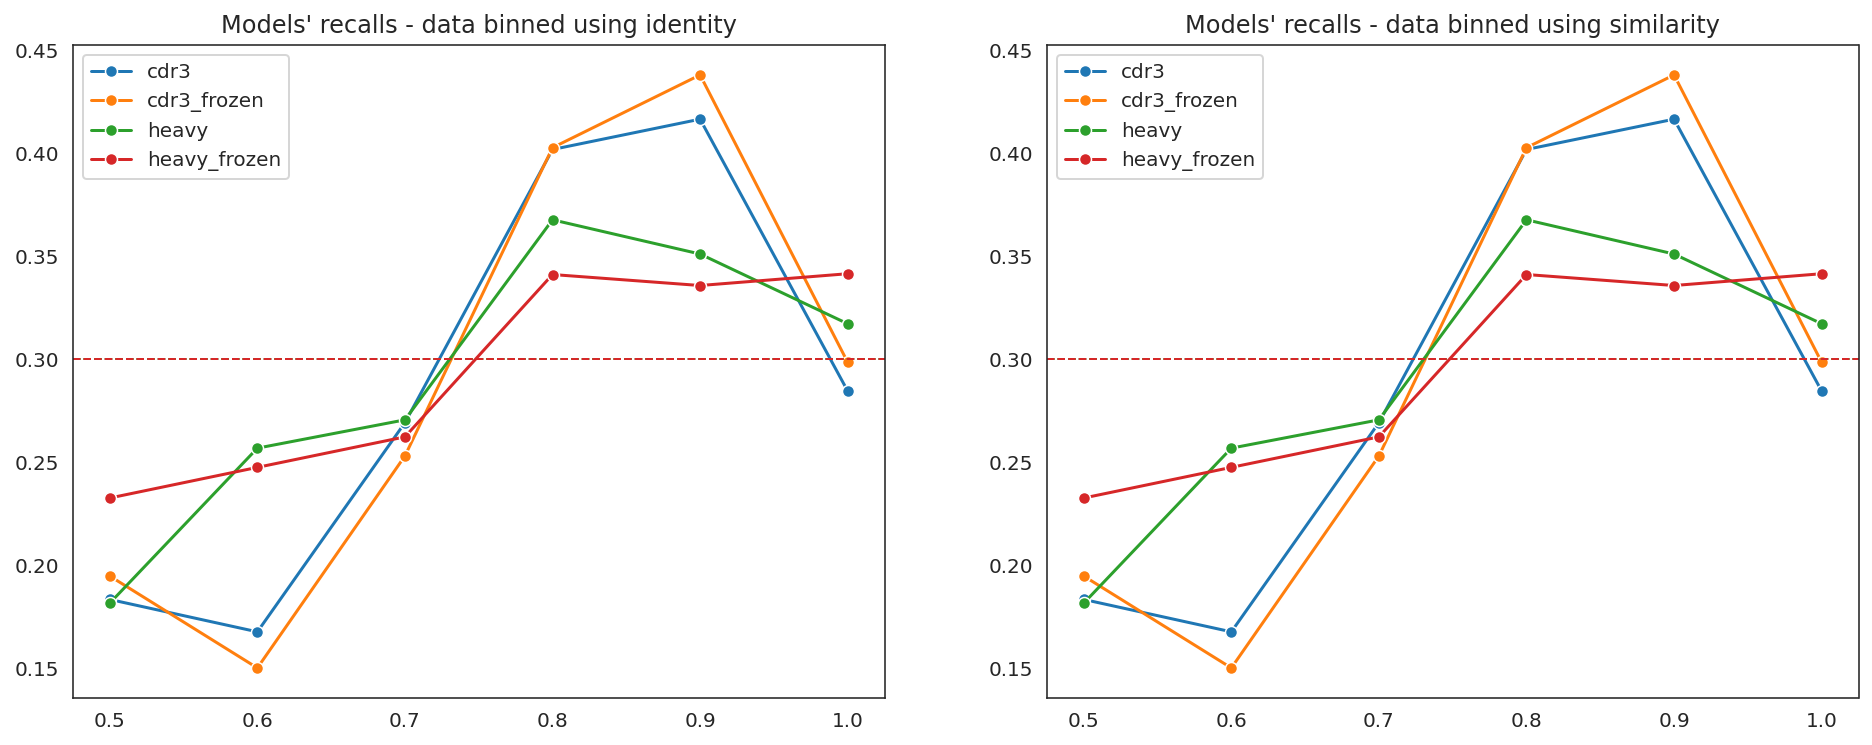

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

lineplot_bins_performance(weighted_id_recalls, 'identity', TARGET_FPR, ax=ax1)
lineplot_bins_performance(weighted_sim_recalls, 'similarity', TARGET_FPR, ax=ax2)

### Non-weighted

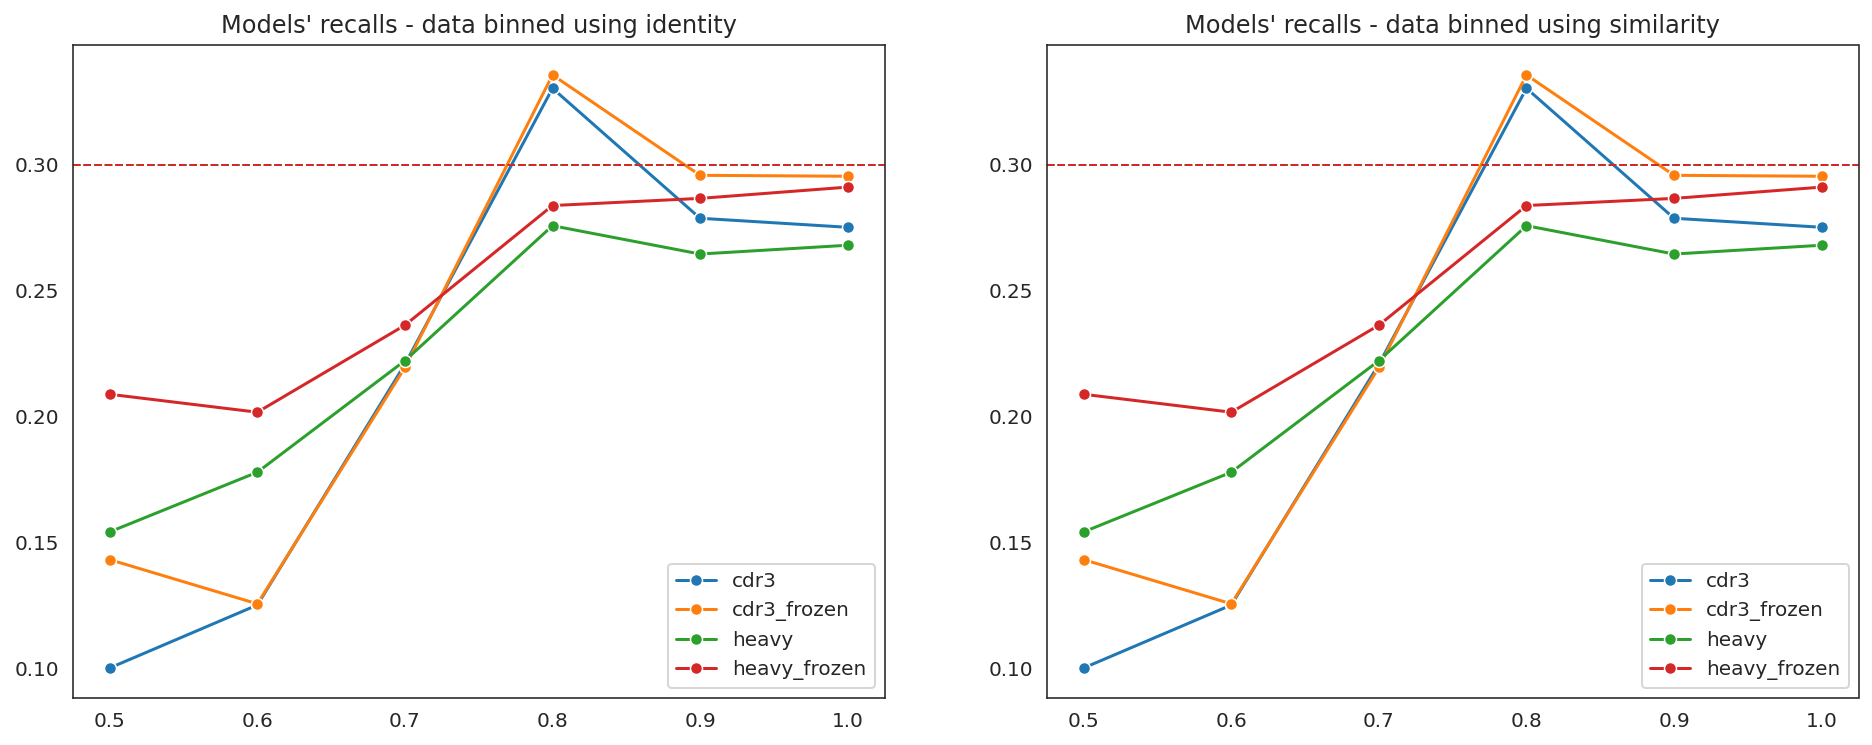

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

lineplot_bins_performance(nonweighted_id_recalls, 'identity', TARGET_FPR, ax=ax1)
lineplot_bins_performance(nonweighted_sim_recalls, 'similarity', TARGET_FPR, ax=ax2)